

# **Install and import required libraries**



In [ ]:
!pip install torchmetrics
!pip install -q -U bitsandbytes
!pip install peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Standard Libraries
import os
import sys
import random
from datetime import datetime

# Transformers Libraries
from transformers import AutoImageProcessor, AutoModel, get_scheduler, BitsAndBytesConfig, AutoFeatureExtractor, ResNetForImageClassification

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# PEFT Libraries
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Data Handling Libraries
from dataclasses import dataclass, field
import numpy as np
import torchmetrics

# Progress Bar Library
from tqdm import tqdm

# Plotting Library
import matplotlib.pyplot as plt


# **Mount GDrive and set paths**

In [ ]:
# To modify with the relevant information
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
project_dir = '/content/gdrive/MyDrive/'
sys.path.append(os.path.join(project_dir, "code/DinoV2/"))

Mounted at /content/gdrive


In [ ]:
# Define the project directory path
#project_dir = '/content/gdrive/MyDrive/SCHISM/'

# Add the DinoV2 code directory to the system path for module imports
sys.path.append(os.path.join(project_dir, "code/DinoV2/github stuff"))

# Define the runs directory path within the project directory
runs_directory = os.path.join(project_dir, 'runs')

# Define the data directory path within the project directory
data_directory = os.path.join(project_dir, 'data')

# **Heads and Model definition**

In [ ]:
class LinearHead(nn.Module):
    def __init__(self, embedding_size=768, img_size=560, num_classes=3, n_features=1):
        super(LinearHead, self).__init__()
        self.embedding_size = embedding_size * n_features
        self.n_features = n_features
        self.head = nn.Sequential(
            nn.BatchNorm2d(self.embedding_size),
            nn.Conv2d(self.embedding_size, num_classes, kernel_size=1, padding=0, bias=True),
            nn.Upsample(size=(img_size, img_size), mode='bilinear', align_corners=False)
        )

    def forward(self, inputs):
        features = inputs["features"]
        patch_feature_size = inputs["image"].shape[-1] // 14
        if self.n_features > 1:
            features = torch.cat(features, dim=-1)[:,1:].permute(0,2,1).reshape(-1,self.embedding_size, patch_feature_size, patch_feature_size)
        else:
            features = features.permute(0,2,1).reshape(-1,self.embedding_size, patch_feature_size, patch_feature_size)
        logits = self.head(features)
        return logits


In [ ]:
@dataclass
class SegmentationHeadConfig:

    embedding_size: int = 768
    n_filter : int = 32
    n_blocks: int = 4
    num_classes : int = 3
    upscale_fn: str = field(default_factory=lambda: ["interpolate", "interpolate", "pixel_shuffle", "pixel_shuffle"])

In [ ]:
class CNNHead(nn.Module):
    def __init__(self):
        super(CNNHead, self).__init__()
        channels = 512
        self.config = SegmentationHeadConfig()
        self.input_conv = nn.Conv2d(
            in_channels=self.config.embedding_size,
            out_channels=channels,
            kernel_size=3,
            padding=1
        )
        self.decoder_convs = nn.ModuleList()
        for i in range(self.config.n_blocks):
            if self.config.upscale_fn[i] == "interpolate":
                self.decoder_convs.append(self._create_decoder_conv_block(channels=channels, kernel_size=3, downscale_factor=i))
            else:
                channels = channels//4
                self.decoder_convs.append(self._create_decoder_up_conv_block(channels=channels, kernel_size=3, downscale_factor=1))

        self.seg_conv = nn.Sequential(
            nn.Conv2d(channels, self.config.num_classes, kernel_size=3, padding=1)
        )

    def _create_decoder_conv_block(self, channels, kernel_size, downscale_factor):
            return nn.Sequential(
                nn.BatchNorm2d(channels),
                nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=1),
            )

    def _create_decoder_up_conv_block(self, channels, kernel_size, downscale_factor):
            return nn.Sequential(
                nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=1),
            )

    def forward(self, inputs):
        features = inputs["features"]
        patch_feature_size = inputs["image"].shape[-1] // 14
        features = features[:,1:].permute(0,2,1).reshape(-1,self.config.embedding_size,patch_feature_size,patch_feature_size)
        x = self.input_conv(features)
        for i in range(self.config.n_blocks):
            if self.config.upscale_fn[i] == "interpolate":
                resize_shape = x.shape[-1]*2 if i >=1 else x.shape[-1]*1.75
                x = F.interpolate(input=x, size=(int(resize_shape),int(resize_shape)), mode="bicubic")
            else:
                x = F.pixel_shuffle(x, 2)
            x = x + self.decoder_convs[i](x)
            if i%2==1 and i!=0:
                x = F.dropout(x, p=0.2)
                x = F.leaky_relu(x)
        return self.seg_conv(x)

In [ ]:
class DinoV2Segmentor(nn.Module):

    head = {
        "linear" : LinearHead,
        "cnn" : CNNHead,
    }

    emb_size = {
        "small" : 384,
        "base" : 768,
        "large" : 1024,
    }

    def __init__(self, num_classes, size="base", n_features=1, peft=False, quantize=False, head_type="linear"):
        super(DinoV2Segmentor, self).__init__()
        assert size in self.emb_size.keys(), "Invalid size"
        assert head_type in self.head.keys(), "Invalid head type"
        self.num_classes = num_classes
        self.n_features = n_features
        self.peft = peft
        self.embedding_size = self.emb_size[size]
        if quantize :
            self.quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=True,
                bnb_4bit_compute_dtype=torch.bfloat16,
            )
            self.backbone = AutoModel.from_pretrained(f'facebook/dinov2-{size}', quantization_config=self.quantization_config)
            self.backbone = prepare_model_for_kbit_training(self.backbone)
        else:
            self.backbone = AutoModel.from_pretrained(f'facebook/dinov2-{size}')

        if peft:
            peft_config = LoraConfig(inference_mode=False, r=32, lora_alpha=32, lora_dropout=0.1, target_modules="all-linear", use_rslora=True)
            self.backbone = get_peft_model(self.backbone, peft_config)
            self.backbone.print_trainable_parameters()
        self.seg_head = self.build_head(head_type)
        print(f"Number of parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad)}")

    def forward(self, x, is_training=False):
        # frozen weights of dino
        with torch.set_grad_enabled(self.peft and is_training):
            if self.n_features == 1:
                features = self.backbone(pixel_values=x).last_hidden_state
            else:
                features = self.backbone(pixel_values=x, output_hidden_states=True)['hidden_states']
        inputs = {"features" : features, "image" : x}
        return self.seg_head(inputs)

    def build_head(self, head_type):
        if head_type == "linear":
            return LinearHead(embedding_size=self.embedding_size, num_classes=self.num_classes, n_features=self.n_features)
        elif head_type == "cnn":
            return CNNHead()
        else:
            raise ValueError(f"Invalid head type: {head_type}")

# **Data Loading**

In [ ]:
import torchvision.transforms.functional as Fv
from torchvision.datasets import VisionDataset
import torchvision

def load_segmentation_data(data_dir, device, num_samples, img_res, train_rocks, test_rocks, num_classes=1, val_split=0.8, batch_size=2):
    # Initialize the training dataset with specified parameters
    train_dataset = EfficientSegmentationDataset(
        data_dir, train_rocks, num_samples=num_samples, num_classes=num_classes, img_res=img_res
    )

    # Initialize the testing dataset with specified parameters (num_samples set to 500 by default)
    test_dataset = EfficientSegmentationDataset(
        data_dir, test_rocks, num_samples=500, num_classes=num_classes, img_res=img_res
    )

    pin_memory_device = 'cuda'

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, pin_memory_device=pin_memory_device)
    val_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True, pin_memory_device=pin_memory_device)

    return {'train': train_loader, 'val': val_loader, 'num_classes': num_classes}

class EfficientSegmentationDataset(VisionDataset):
    def __init__(self, data_dir, rock_names, num_classes=3, num_samples=None, crop_size = (224,224), p=0.5, img_res=224, save_dir=None):
        super().__init__(data_dir, transforms=None)
        print("Loading data ...")
        # The stats have been computed on our side. These values represents the mean and stddev pour each rock dataset
        self.data_stats = {
            "sample1" : [
                np.array([123.07921846875976]*3)/255.0, np.array([84.04993142526148]*3)/255.0
            ],

            "sample2" : [
                np.array([117.92807255795907]*3)/255.0, np.array([80.61479412614699]*3)/255.0
            ],

            "sample3" : [
                np.array([119.7933619436969]*3)/255.0, np.array([80.18348841827216]*3)/255.0
            ],

        }
        self.img_data = [np.lib.format.open_memmap(data_dir+f"/{rock}_img.npy", dtype=np.uint8, mode='r') for rock in rock_names]
        self.mask_data = [np.lib.format.open_memmap(data_dir+f"/{rock}_mask.npy", dtype=np.uint8, mode='r') for rock in rock_names]
        self.rock_names = rock_names
        self.crop_size=crop_size
        self.p=p
        self.OFFSET = 128
        self.IMG_RES = img_res
        self.save_dir = save_dir
        self.num_classes = num_classes
        self.inference_mode = False

        if num_samples is None:
          self.num_samples = len(self.img_data[0])
        else:
          self.num_samples = num_samples

        self.num_datasets = len(self.img_data)

    def get_random_crop_params(self):
        h, w = (1014, 976)
        th, tw = self.crop_size

        if h < th or w < tw:
            raise ValueError(f"Required crop size {(th, tw)} is larger than input image size {(h, w)}")

        if w == tw and h == th:
            return 0, 0, h, w

        i = torch.randint(0, h - th + 1, size=(1,)).item()
        j = torch.randint(0, w - tw + 1, size=(1,)).item()

        return i, j, th, tw


    def _weights_calc(self, mask, temperature=50.0):
        # Calculate the class frequencies
        values_to_count = [85, 170, 255]
        counts = np.bincount(mask.ravel())[values_to_count]
        class_ratio = counts / np.sum(counts)
        u_weights = 1/class_ratio
        weights = np.nan_to_num(u_weights, posinf=-np.inf)
        weights = F.softmax(torch.from_numpy(weights).float()/temperature, dim=-1)
        if torch.any(torch.isnan(weights)):
            print(weights)
            print(class_ratio)
            print(u_weights)
            raise
        return weights

    def __getitem__(self, idx):
        # random crop
        i, j, h, w = self.get_random_crop_params()
        idx_x = i
        idx_y = j
        if idx_x < self.OFFSET:
            idx_x += self.OFFSET
        if idx_y < self.OFFSET:
            idx_y += self.OFFSET

        # random crop avant d'accéder au memmap
        dataset_index = idx % self.num_datasets
        data_idx = (idx // self.num_datasets)

        img = self.img_data[dataset_index][data_idx, idx_x:h+idx_x, idx_y:w+idx_y, :].copy()
        mask = self.mask_data[dataset_index][data_idx, idx_x:h+idx_x, idx_y:w+idx_y].copy()

        #img = self.non_local_means_filter(img, h=15, templateWindowSize=7, searchWindowSize=21)

        weights = self._weights_calc(mask)

        img = torch.from_numpy(img.transpose((2, 0, 1))).contiguous()/255.0 # forcément en [0 255] car uint8
        mask = torch.from_numpy(mask).contiguous()/255.0

        img = F.interpolate(input=img.unsqueeze(0), size=(self.IMG_RES, self.IMG_RES), mode="bicubic", align_corners=False).squeeze()
        mask = F.interpolate(input=mask.unsqueeze(0).unsqueeze(0), size=(self.IMG_RES, self.IMG_RES), mode="nearest").squeeze()

        # random h flip
        r = torch.rand(1)
        if r < self.p and not self.inference_mode:
            img = torchvision.transforms.functional.hflip(img)
            mask = torchvision.transforms.functional.hflip(mask)

        # random v flip
        r = torch.rand(1)
        if r < self.p and not self.inference_mode:
            img = torchvision.transforms.functional.vflip(img)
            mask = torchvision.transforms.functional.vflip(mask)


        # Random brightness and contrast jittering
        if not self.inference_mode:
            brightness = random.uniform(0.8, 1.2)
            contrast = random.uniform(0.8, 1.2)
            img = torchvision.transforms.functional.adjust_brightness(img, brightness)
            img = torchvision.transforms.functional.adjust_contrast(img, contrast)

        # Adjust gamma
        if not self.inference_mode:
            gamma = random.uniform(0.5, 1.5)
            img = torchvision.transforms.functional.adjust_gamma(img, gamma)

        # normalize
        m = self.data_stats[self.rock_names[dataset_index]][0]
        s = self.data_stats[self.rock_names[dataset_index]][1]

        if self.num_classes > 2:
           mask = (mask* self.num_classes).long()-1

        return torchvision.transforms.functional.normalize(img, m, s).float(), mask, weights, img

    def __len__(self):
        return self.num_datasets * self.num_samples

In [ ]:
# Define the path to the numpy data directory. All data are in npy format
dataset_name = "Alhammadi"

# Set the device to 'cuda' for GPU usage
device = 'cuda'

# Define the training and testing rock samples
train_rocks = ['sample1', 'sample2']
test_rocks = ["sample3"]

# Set the batch size for data loading
batch_size = 15

# Set the number of epochs for training
epoch_nb = 20

# Specify the size of the model (small, base or large)
size_network = "base"

# Specify segmentation head type (linear or CNN)
head_type = "cnn"

# Quantized LoRA ?
peft= True
quantize= True

# Set the image resolution.
img_res = 560

# Set the number of samples to be used for training.
# This number represents the amount of 2D slice that will be randomly selected per dataset (in our case 500*2)
num_samples = 50

# Using the datasets of Alhammadi et al. (2017), we have 3 classes
num_classes = 3

# Set the learning rate
lr=1e-4

# set the weight decay
weight_decay=1e-4

# Get the number of datasets based on the length of training rocks
num_dataset = len(train_rocks)

# Data loading
data_npy = os.path.join(project_dir, "npy_data", dataset_name)
dataloaders = load_segmentation_data(data_dir=data_npy,
                                     device=device,
                                     img_res=img_res,
                                     num_samples=num_samples,
                                     train_rocks=train_rocks,
                                     test_rocks=test_rocks,
                                     num_classes=num_classes,
                                     batch_size=batch_size)

Loading data ...
Loading data ...


# **Training**

/content/gdrive/MyDrive/runs/DINOv2_base_50_560/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

trainable params: 5,308,416 || all params: 91,888,896 || trainable%: 5.7770
Number of parameters: 13727235
Number of parameters: 13727235
New model


------------------
--- Epoch 1/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
 29%|██▊       | 2/7 [00:36<01:20, 16.03s/batch, loss=1.04, mIoU=tensor(0.2124, device='cuda:0')]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:17<00:00,  3.23batch/s, los



------------------
--- Epoch 2/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:08<00:00,  3.67batch/s, loss=0.637, mIoU=tensor(0.5302, device='cuda:0')]




------------------
--- Epoch 3/20 ---


100%|██████████| 250/250 [01:08<00:00,  3.67batch/s, loss=0.589, mIoU=tensor(0.6654, device='cuda:0')]




------------------
--- Epoch 4/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
 10%|█         | 26/250 [00:07<00:58,  3.80batch/s, loss=0.487, mIoU=tensor(0.7425, device='cuda:0')]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:08<00:00,  3.66batch/s, loss=0.489, mIoU=tensor(0.7430, device='cuda:0')]




------------------
--- Epoch 5/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:06<00:00,  3.73batch/s, loss=0.534, mIoU=tensor(0.6727, device='cuda:0')]




------------------
--- Epoch 6/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.70batch/s, loss=0.464, mIoU=tensor(0.7040, device='cuda:0')]




------------------
--- Epoch 7/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.72batch/s, loss=0.476, mIoU=tensor(0.7729, device='cuda:0')]




------------------
--- Epoch 8/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.68batch/s, loss=0.454, mIoU=tensor(0.7958, device='cuda:0')]




------------------
--- Epoch 9/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.71batch/s, loss=0.494, mIoU=tensor(0.7850, device='cuda:0')]




------------------
--- Epoch 10/20 ---


 14%|█▍        | 1/7 [00:08<00:48,  8.05s/batch, loss=0.323, mIoU=tensor(0.8166, device='cuda:0')]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.70batch/s, loss=0.432, mIoU=tensor(0.7687, device='cuda:0')]




------------------
--- Epoch 11/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.71batch/s, loss=0.422, mIoU=tensor(0.7396, device='cuda:0')]




------------------
--- Epoch 12/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
 29%|██▊       | 2/7 [00:15<00:37,  7.53s/batch, loss=0.323, mIoU=tensor(0.8260, device='cuda:0')]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.73batch/s, loss=0.479, mIoU=tensor(0.7802, device='cuda:0')]




------------------
--- Epoch 13/20 ---


100%|██████████| 250/250 [01:07<00:00,  3.72batch/s, loss=0.394, mIoU=tensor(0.7730, device='cuda:0')]




------------------
--- Epoch 14/20 ---


 14%|█▍        | 1/7 [00:08<00:48,  8.07s/batch, loss=0.321, mIoU=tensor(0.8224, device='cuda:0')]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:06<00:00,  3.74batch/s, loss=0.444, mIoU=tensor(0.7699, device='cuda:0')]




------------------
--- Epoch 15/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.72batch/s, loss=0.429, mIoU=tensor(0.7781, device='cuda:0')]




------------------
--- Epoch 16/20 ---


 29%|██▊       | 2/7 [00:14<00:35,  7.06s/batch, loss=0.309, mIoU=tensor(0.8400, device='cuda:0')]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:06<00:00,  3.74batch/s, loss=0.421, mIoU=tensor(0.7674, device='cuda:0')]




------------------
--- Epoch 17/20 ---


100%|██████████| 250/250 [01:06<00:00,  3.74batch/s, loss=0.557, mIoU=tensor(0.7876, device='cuda:0')]




------------------
--- Epoch 18/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:06<00:00,  3.74batch/s, loss=0.463, mIoU=tensor(0.7780, device='cuda:0')]




------------------
--- Epoch 19/20 ---


 29%|██▊       | 2/7 [00:15<00:36,  7.39s/batch, loss=0.308, mIoU=tensor(0.8430, device='cuda:0')]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:07<00:00,  3.72batch/s, loss=0.412, mIoU=tensor(0.7697, device='cuda:0')]




------------------
--- Epoch 20/20 ---


  0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-9-4669f7df0ecf>:81: RuntimeWarning: divide by zero encountered in divide
  u_weights = 1/class_ratio
100%|██████████| 250/250 [01:06<00:00,  3.74batch/s, loss=0.408, mIoU=tensor(0.7814, device='cuda:0')]


The maximum IoU value in the validation set is: 0.7958127856254578


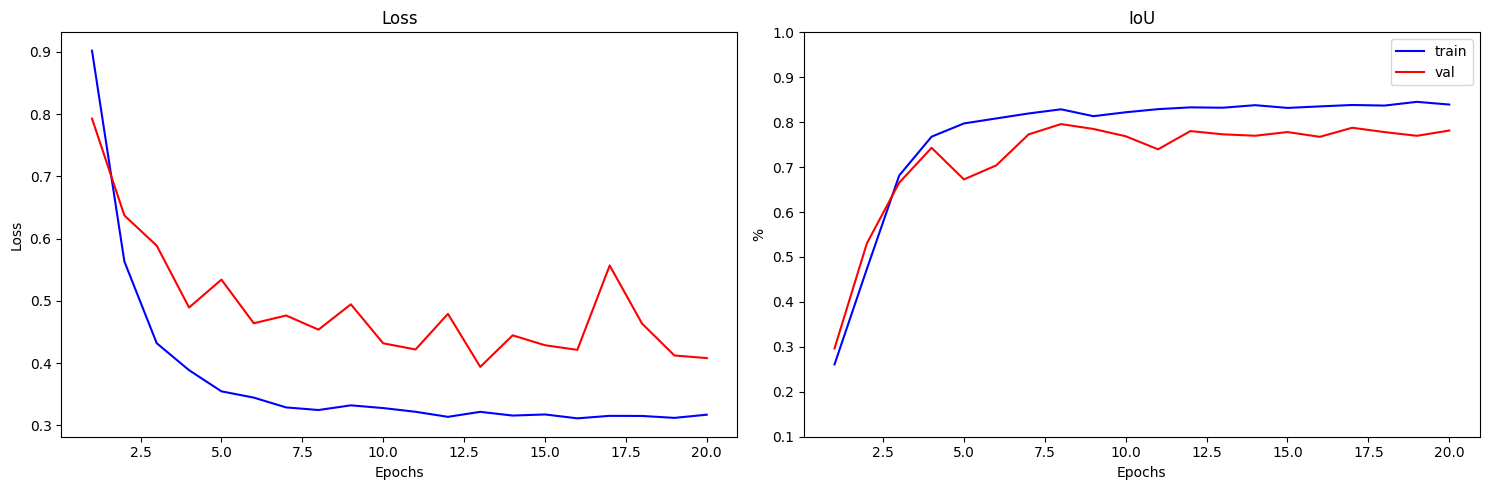

In [ ]:
# Define the directory to save the results
save_directory = runs_directory +'/DINOv2_'+ f"{size_network}_{num_samples}_{img_res}/"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

print(save_directory)

def plot_learning_curves(loss_dict, jaccard_dict, MODEL_FOLDER):
    """
    Plots the learning curves for loss and IoU over epochs.

    Args:
        loss_dict (dict): Dictionary containing loss values for training and validation.
        jaccard_dict (dict): Dictionary containing IoU values for training and validation.
        MODEL_FOLDER (str): Directory to save the plot.
    """
    # Extract epochs and corresponding loss and IoU values
    epochs = list(loss_dict['train'].keys())
    train_loss_values = [loss_dict['train'][epoch] for epoch in epochs]
    val_loss_values = [loss_dict['val'][epoch] for epoch in epochs]
    train_jaccard_values = [jaccard_dict['train']['mean_iou'][epoch - 1] for epoch in epochs]
    val_jaccard_values = [jaccard_dict['val']['mean_iou'][epoch - 1] for epoch in epochs]

    # Create subplots for loss and IoU
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    ax0 = axes[0]
    ax2 = axes[1]

    # Plot loss values
    ax0.plot(epochs, train_loss_values, 'b-', label='train')
    ax0.plot(epochs, val_loss_values, 'r-', label='val')
    ax0.set_title('Loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')

    # Plot IoU values
    ax2.plot(epochs, train_jaccard_values, 'b-', label='train')
    ax2.plot(epochs, val_jaccard_values, 'r-', label='val')
    ax2.set_title('IoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('%')
    ax2.set_ylim(0.1, 1.0)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_directory, 'learning_curves.png'), dpi=300)

def save_experiment_params(num_samples_train, batch_size, num_dataset, EPOCH_NB, lr, weight_decay, model):
    """
    Saves the experiment parameters and model state dictionary.

    Args:
        num_samples_train (int): Number of training samples.
        batch_size (int): Batch size.
        num_dataset (int): Number of datasets.
        EPOCH_NB (int): Number of epochs.
        lr (float): Learning rate.
        weight_decay (float): Weight decay.
        model (torch.nn.Module): Trained model.
    """
    # Create folder name based on current date and time
    current_time = datetime.now().strftime("%d-%m-%Y-%H-%M")
    folder_name = f'DINOv2-{current_time}'

    # Create the directory if it doesn't exist
    folder_path = os.path.join(save_directory, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    # Save the experiment parameters to a text file
    params_file_path = os.path.join(folder_path, 'experiment_params.txt')
    with open(params_file_path, 'w') as f:
        f.write(f'num_samples_train={num_samples_train}\n')
        f.write(f'batch_size={batch_size}\n')
        f.write(f'num_dataset={num_dataset}\n')
        f.write(f'EPOCH_NB={EPOCH_NB}\n')
        f.write(f'lr={lr}\n')
        f.write(f'weight_decay={weight_decay}\n')

    # Save the model state dict
    model_file_path = os.path.join(folder_path, 'model_state_dict.pth')
    torch.save(model.state_dict(), model_file_path)

def save_dicts(loss_dict, jaccard_dict, file_path):
    """
    Saves the loss and IoU dictionaries as PyTorch tensors.

    Args:
        loss_dict (dict): Dictionary containing loss values for training and validation.
        jaccard_dict (dict): Dictionary containing IoU values for training and validation.
        file_path (str): Directory to save the tensors.
    """
    # Convert dictionaries to PyTorch tensors
    loss_tensor = {
        'train': torch.tensor(list(loss_dict['train'].values())),
        'val': torch.tensor(list(loss_dict['val'].values()))
    }

    jaccard_tensor = {
        'train': torch.tensor(jaccard_dict['train']['mean_iou']),
        'val': torch.tensor(jaccard_dict['val']['mean_iou'])
    }

    # Save tensors to files
    torch.save(loss_tensor, os.path.join(file_path, 'loss_tensor.pt'))
    torch.save(jaccard_tensor, os.path.join(file_path, 'iou_tensor.pt'))

def train_segmentation_model(model, dataloaders, optimizer, scheduler, device, epoch_nb=10):
    """
    Trains the segmentation model.

    Args:
        model (torch.nn.Module): The segmentation model.
        dataloaders (dict): Dictionary containing training and validation dataloaders.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        device (str): Device to run the training on ('cuda' or 'cpu').
        epoch_nb (int): Number of epochs to train.

    Returns:
        torch.nn.Module: Trained model.
    """
    if device == "cuda":
        scaler = torch.cuda.amp.GradScaler()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True

    jaccard = torchmetrics.classification.MulticlassJaccardIndex(num_classes=3, ignore_index=-1).to(device)

    print('New model')
    epoch_init = 1
    loss_dict = {}
    metrics_dict = {}
    monitored_metrics = ["mean_iou"]
    for phase in ['train', 'val']:
        loss_dict[phase] = {}
        metrics_dict[phase] = {}
        for m in monitored_metrics:
            metrics_dict[phase][m] = []

    best_train_iou = 0
    best_val_iou = 0
    best_val_loss = 100000
    for epoch in range(epoch_init, epoch_init+epoch_nb):
        print('\n')
        print('-' * 18)
        print('--- Epoch {}/{} ---'.format(epoch, epoch_init+epoch_nb-1))

        for phase in ['train', 'val']:
            if phase == 'train':
                is_training = True
                model.train()
            else:
                model.eval()
                is_training = False

            # Initialize metrics for this phase
            running_loss = 0.0  # Accumulate losses over the epoch
            running_iou = 0.0
            with tqdm(total=len(dataloaders[phase]), unit='batch') as p:

                for batch_idx, (inputs, labels, weights, _) in enumerate(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    weights = weights.to(device)
                    optimizer.zero_grad()

                    batch_weights = torch.mean(weights, dim=0)
                    with torch.set_grad_enabled(is_training):
                        with torch.autocast(device_type=device, dtype=torch.float16):
                            outputs = model(inputs, is_training).squeeze()
                            loss = F.cross_entropy(outputs, labels.squeeze(), ignore_index=-1, weight=batch_weights, label_smoothing=0.05)
                            if is_training:
                                if device=="cuda":
                                    scaler.scale(loss).backward()
                                    scaler.step(optimizer)
                                    scaler.update()
                                else:
                                    loss.backward()
                                    optimizer.step()
                                scheduler.step()

                    # Update running loss and correct prediction count
                    running_loss += loss.item()

                    with torch.no_grad():
                        mIoU = jaccard(outputs, labels.squeeze())#mean_iou.compute(predictions=preds, references=labels.squeeze(), num_labels=3, ignore_index=255)
                        running_iou += mIoU

                    # Update the progress bar
                    p.set_postfix({'loss': running_loss/(batch_idx+1),  "mIoU" : running_iou/(batch_idx+1)})
                    p.update(1)

                # Calculate loss, accuracy, and Jaccard Index for this epoch
                epoch_loss = running_loss /(batch_idx+1)
                epoch_iou = running_iou /(batch_idx+1)
                if not is_training:
                    if epoch_iou > best_val_iou:
                        best_val_iou = epoch_iou
                        torch.save(model.state_dict(), save_directory+"model_best_iou.pth")

                    if epoch_loss < best_val_loss:
                        best_val_loss = epoch_loss
                        torch.save(model.state_dict(), save_directory+"model_best_loss.pth")


                loss_dict[phase][epoch] = epoch_loss
                metrics_dict[phase]["mean_iou"].append(epoch_iou.cpu().item())

    # Get the maximum IoU value from the 'val' phase
    max_val_iou = max(metrics_dict['val']["mean_iou"])

    print(f"The maximum IoU value in the validation set is: {max_val_iou}")
    save_dicts(loss_dict, metrics_dict, save_directory)

    plot_learning_curves(loss_dict, metrics_dict, save_directory)

    return model


# Calculate the number of training steps
num_training_steps = epoch_nb * len(dataloaders["train"])

# Initialize the model
model = DinoV2Segmentor(num_classes=3, size=size_network, peft=peft, quantize=quantize, head_type=head_type)
model.to(device)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Define the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=10, num_training_steps=num_training_steps)

print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Train the model
model = train_segmentation_model(model, dataloaders, optimizer, lr_scheduler, device, epoch_nb)

# Save the experiment parameters and model state
save_experiment_params(num_samples,
                       batch_size,
                       num_dataset,
                       epoch_nb,
                       lr,
                       weight_decay,
                       model)

# **Inference**

In [ ]:
# Initialize the model
model = DinoV2Segmentor(num_classes=3, size=size_network, peft=peft, quantize=quantize, head_type=head_type)
model.to(device)

# Load state dictionary
model_name = "model_best_iou.pth"
checkpoint = torch.load(os.path.join(save_directory, model_name), map_location=torch.device('cpu'))

# Load the model's state dictionary
model.load_state_dict(checkpoint)

# Set the model to evaluation mode
model.eval()

`low_cpu_mem_usage` was None, now set to True since model is quantized.


trainable params: 5,308,416 || all params: 91,888,896 || trainable%: 5.7770
Number of parameters: 13727235


DinoV2Segmentor(
  (backbone): PeftModel(
    (base_model): LoraModel(
      (model): Dinov2Model(
        (embeddings): Dinov2Embeddings(
          (patch_embeddings): Dinov2PatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): Dinov2Encoder(
          (layer): ModuleList(
            (0-11): 12 x Dinov2Layer(
              (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
              (attention): Dinov2Attention(
                (attention): Dinov2SelfAttention(
                  (query): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=3

torch.Size([3, 560, 560])
torch.Size([1, 3, 560, 560])
torch.Size([1, 560, 560])
Largest IoU value for 'val' tensors: 0.7958127856254578
Smallest loss value for 'val' tensors: 0.393740177154541
Image shape: torch.Size([3, 560, 560])
Mask shape: torch.Size([1, 560, 560])
Minimum value of the image: 0.01843324862420559
Maximum value of the image: 0.944852352142334
Minimum value of the mask: 0
Maximum value of the mask: 2


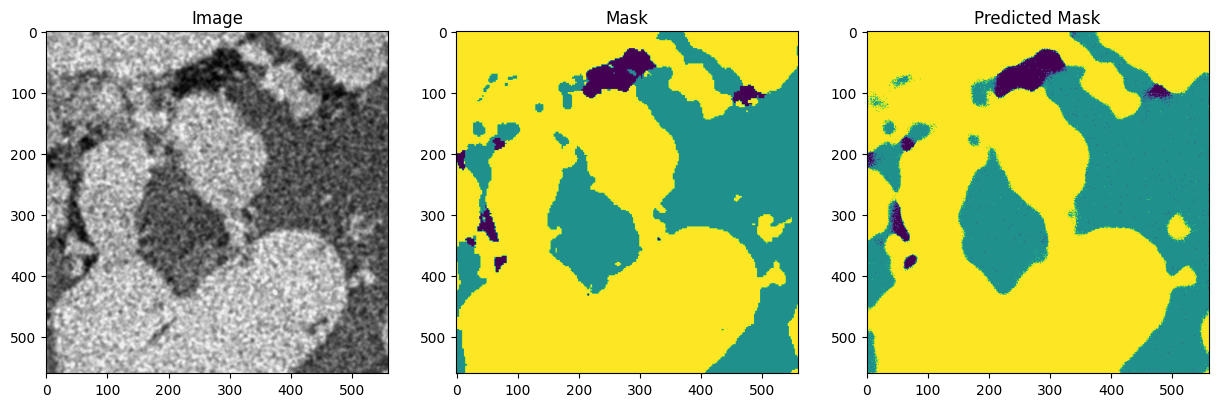

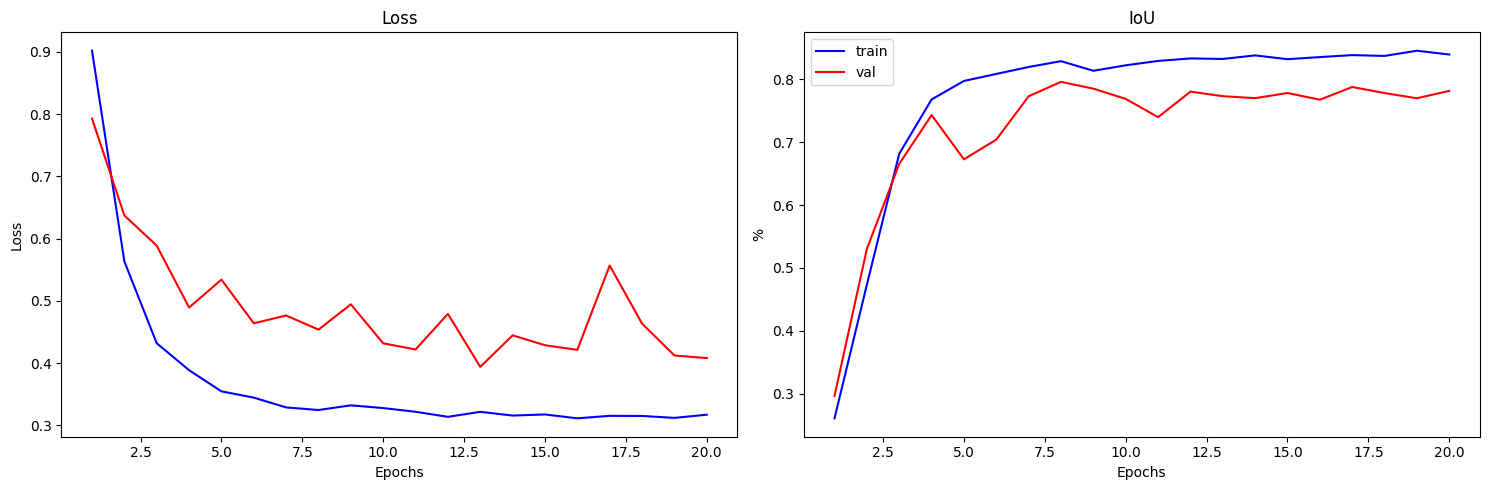

In [ ]:
# Get a batch of validation data
data_iter = iter(dataloaders['val'])
data_batch = next(data_iter)

# Extract the first image and mask from the batch
image_presentation = data_batch[3][0]  # First image for presentation
image = data_batch[0][0].unsqueeze(0)  # First image with batch dimension added
mask = data_batch[1][0].unsqueeze(0)   # First mask with batch dimension added

print(image_presentation.shape)
print(image.shape)
print(mask.shape)

# Move the model to the specified device (CPU or GPU)
model.to(device)

# Predict the mask using the model
with torch.no_grad():
    image = image.to(device)  # Move the image to the specified device
    predicted_mask = model(image)  # Get the predicted mask from the model
    preds = torch.argmax(predicted_mask, dim=1).cpu()  # Get the class with the highest probability for each pixel

def pred_function(image, mask, preds):
    """
    Displays the image, ground truth mask, and predicted mask.

    Args:
        image (torch.Tensor): The input image.
        mask (torch.Tensor): The ground truth mask.
        preds (torch.Tensor): The predicted mask.
    """
    # Print the shape and value range of the image and mask
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Minimum value of the image: {image.min().item()}")
    print(f"Maximum value of the image: {image.max().item()}")
    print(f"Minimum value of the mask: {mask.min().item()}")
    print(f"Maximum value of the mask: {mask.max().item()}")

    # Create subplots to display the image, mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the image
    image = image.numpy().transpose(1, 2, 0)  # Convert to numpy and transpose for correct display
    axes[0].imshow(image)
    axes[0].set_title('Image')

    # Plot the ground truth mask
    mask = mask[0].numpy()  # Convert to numpy
    axes[1].imshow(mask)
    axes[1].set_title('Mask')

    # Plot the predicted mask
    preds = preds.squeeze().numpy()  # Convert to numpy and remove extra dimensions
    axes[2].imshow(preds)
    axes[2].set_title('Predicted Mask')

    plt.show()

def plot_learning_curves_from_pt(loss_tensor_file, jaccard_tensor_file):
    """
    Plots the learning curves for loss and IoU from saved tensor files.

    Args:
        loss_tensor_file (str): Path to the file containing loss tensors.
        jaccard_tensor_file (str): Path to the file containing IoU tensors.
    """
    # Load tensors from files
    loss_tensor = torch.load(loss_tensor_file)
    jaccard_tensor = torch.load(jaccard_tensor_file)

    # Convert tensors to lists
    train_loss_values = loss_tensor['train'].tolist()
    val_loss_values = loss_tensor['val'].tolist()
    train_jaccard_values = jaccard_tensor['train'].tolist()
    val_jaccard_values = jaccard_tensor['val'].tolist()

    # Extract epochs
    epochs = list(range(1, len(train_loss_values) + 1))

    # Plot learning curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss values
    ax0 = axes[0]
    ax0.plot(epochs, train_loss_values, 'b-', label='train')
    ax0.plot(epochs, val_loss_values, 'r-', label='val')
    ax0.set_title('Loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')

    # Plot IoU values
    ax2 = axes[1]
    ax2.plot(epochs, train_jaccard_values, 'b-', label='train')
    ax2.plot(epochs, val_jaccard_values, 'r-', label='val')
    ax2.set_title('IoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('%')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Load the saved tensors
loss_tensor = torch.load(os.path.join(save_directory, 'loss_tensor.pt'))
jaccard_tensor = torch.load(os.path.join(save_directory, 'iou_tensor.pt'))

# Find the largest IoU value for 'val' tensors
largest_iou_val = jaccard_tensor['val'].max().item()

# Find the smallest loss value for 'val' tensors
smallest_loss_val = loss_tensor['val'].min().item()

# Print the largest IoU and smallest loss values
print("Largest IoU value for 'val' tensors:", largest_iou_val)
print("Smallest loss value for 'val' tensors:", smallest_loss_val)


# Display the image, ground truth mask, and predicted mask
pred_function(image_presentation.cpu(), mask.cpu(), preds.cpu())


# Plot the learning curves
plot_learning_curves_from_pt(os.path.join(save_directory, 'loss_tensor.pt'),
                             os.path.join(save_directory, 'iou_tensor.pt'))